In [1]:
# this file is for reading temporary files generated

import pickle

In [2]:
# ignore ray actors that were accidentally included in the temp files

class DummyActorHandle:
    # signature should match Ray’s ActorHandle._deserialization_helper
    @staticmethod
    def _deserialization_helper(state, rref=False, outer_object_ref=None):
        # just drop it
        return None

    def __init__(self, *args, **kwargs):
        # any ctor; won’t be used
        pass

In [3]:
class NoActorsUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # match the real ActorHandle’s module and name
        if module == "ray.actor" and name == "ActorHandle":
            return DummyActorHandle
        # if your version of Ray is different, you may need:
        if module.startswith("ray._private") and name == "ActorHandle":
            return DummyActorHandle
        return super().find_class(module, name)

In [4]:

import numpy as np

temp_names  = ['adult', 'MagicTelescope', 'mushroom', 'shuttle', 'covertype']
agent_names = ["LinearTS", "LinearTS_NTSver", "MCLogisticBARTTS"]
N_sim       = 8

all_regrets = {}
all_times   = {}

ds_results = {}

import os

for ds in temp_names:
    max_sim = N_sim
    for sim in range(N_sim):
        pkl = f"./temp_results/temp_simulation_{ds}_{sim}.pkl"
        if not os.path.exists(pkl):
            max_sim = sim
            print(f"Missing file: {pkl},  total sim {sim}")
            break
            
    for sim in range(max_sim):
        pkl = f"./temp_results/temp_simulation_{ds}_{sim}.pkl"
        with open(pkl, "rb") as f:
            result = NoActorsUnpickler(f).load()

        # On first file for this dataset, do the init:
        if sim == 0:
            n_draws = result[1].shape[0]
            all_regrets = dict()
            all_times   = dict()
            for i, agent in enumerate(agent_names):
                all_regrets[agent] = np.zeros((max_sim, n_draws), dtype=float)
                all_times  [agent] = np.zeros((max_sim, n_draws), dtype=float)

        # Fill in this sim’s data:
        for i, agent in enumerate(agent_names):
            all_regrets[agent][sim, :] = result[1][:, i]
            all_times  [agent][sim, :] = result[2][:, i]

    sc_results = {
        'regrets': all_regrets,
        'times'  : all_times
    }
    ds_results[ds] = sc_results

Missing file: ./temp_results/temp_simulation_adult_3.pkl,  total sim 3
Missing file: ./temp_results/temp_simulation_MagicTelescope_6.pkl,  total sim 6
Missing file: ./temp_results/temp_simulation_mushroom_7.pkl,  total sim 7
Missing file: ./temp_results/temp_simulation_shuttle_1.pkl,  total sim 1
Missing file: ./temp_results/temp_simulation_covertype_2.pkl,  total sim 2


In [5]:
from compare_agents import (
    print_summary_results, plot_comparison_results
)

In [6]:
print_summary_results(ds_results)


=== adult Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 2264.33 (±30.07)
  LinearTS_NTSver: 2295.00 (±32.40)
  MCLogisticBARTTS: 1854.67 (±13.47)

Average computation times (seconds):
  LinearTS: 1.7917 (±0.0212)
  LinearTS_NTSver: 4.4498 (±0.0621)
  MCLogisticBARTTS: 5472.2207 (±301.9420)


=== MagicTelescope Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 2709.83 (±19.40)
  LinearTS_NTSver: 2701.00 (±24.59)
  MCLogisticBARTTS: 1906.17 (±12.24)

Average computation times (seconds):
  LinearTS: 1.6430 (±0.0426)
  LinearTS_NTSver: 3.8151 (±0.0543)
  MCLogisticBARTTS: 5186.7280 (±146.3423)


=== mushroom Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 882.29 (±9.44)
  LinearTS_NTSver: 876.71 (±15.33)
  MCLogisticBARTTS: 127.43 (±10.32)

Average computation times (seconds):
  LinearTS: 1.6137 (±0.0183)
  LinearTS_NTSver: 4.6234 (±0.0843)
  MCLogisticBARTTS: 4270.3134 (±268.5556)


=== shuttle Scenario ===

Final cumulative regrets (mea

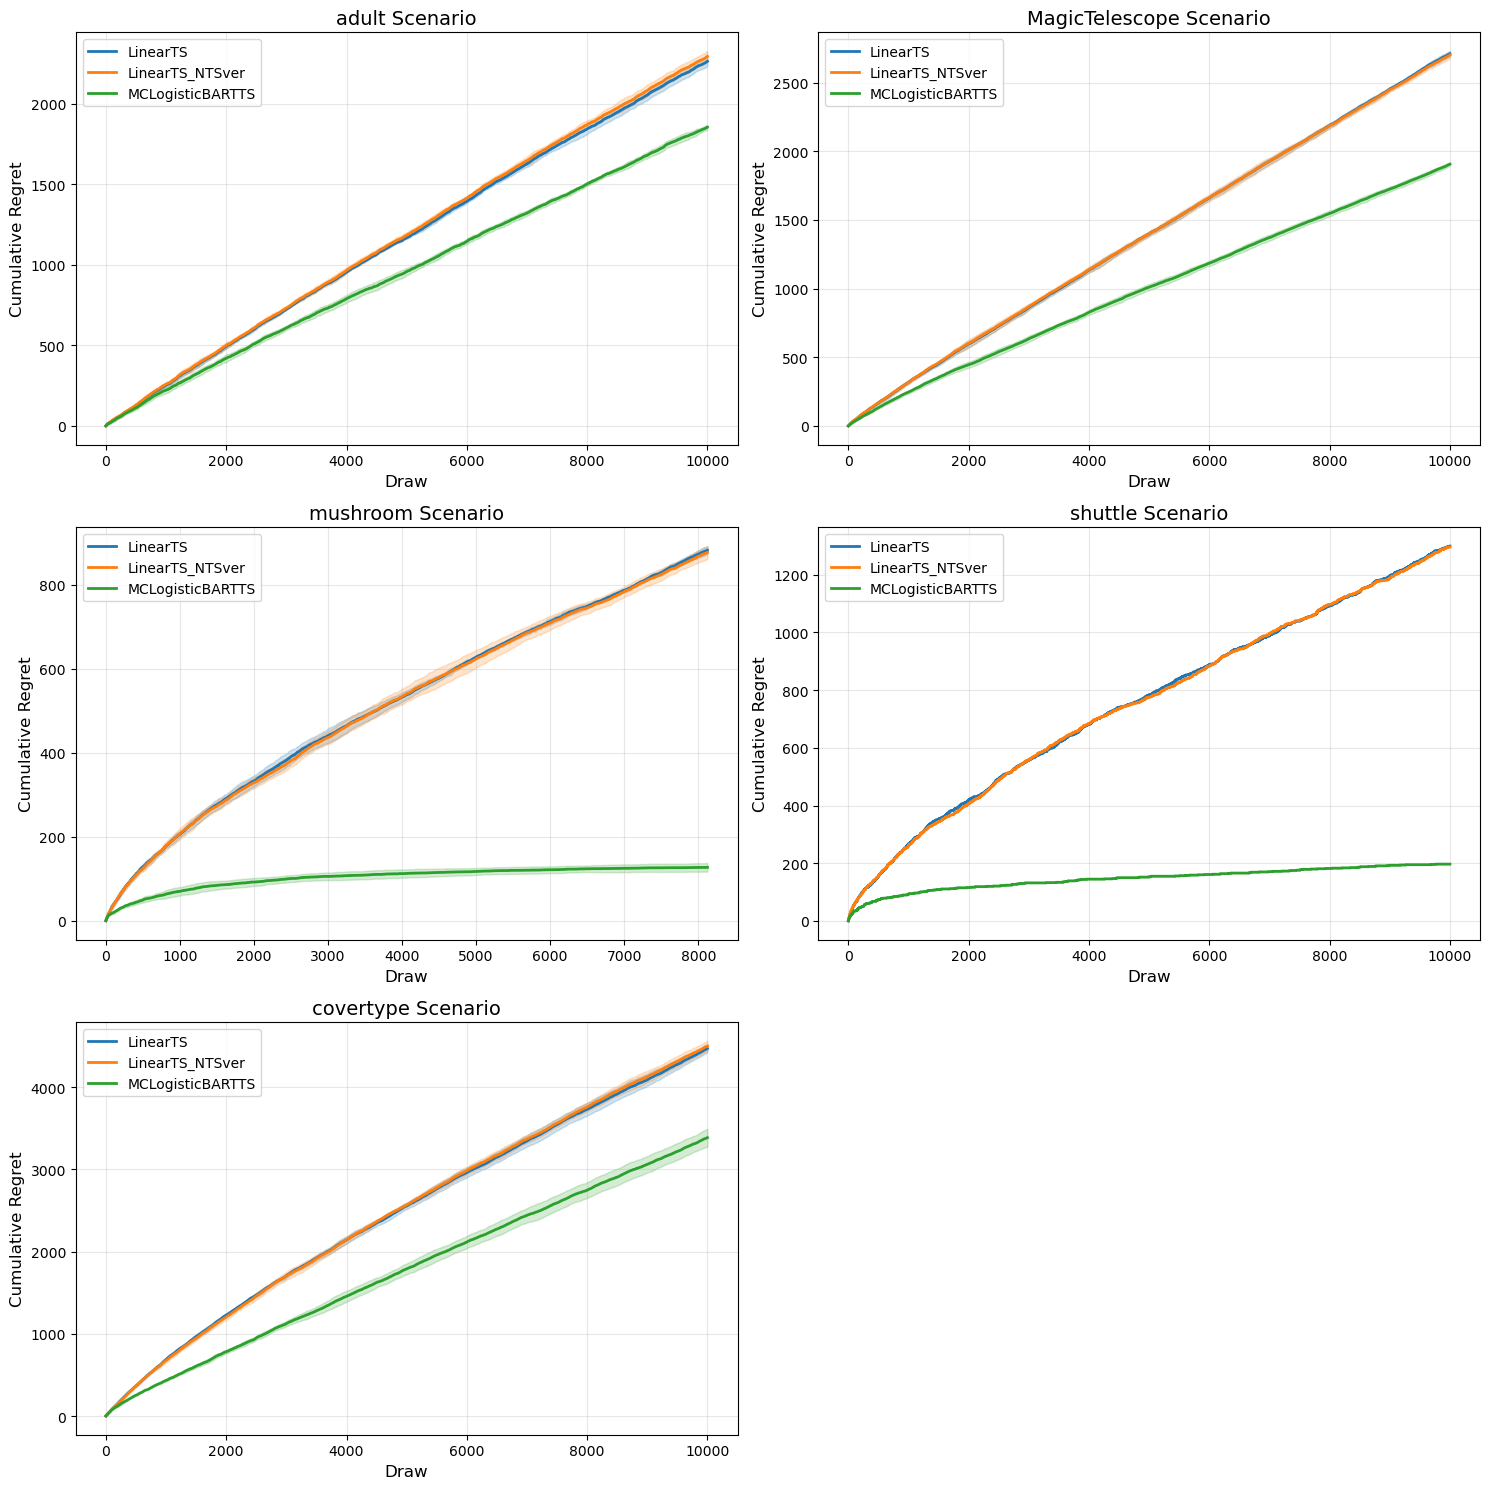

In [7]:
plot_comparison_results(ds_results)